# Notebook Overview : Golbal visualization

This notebook allows the visualization of the 4 TiMeS datasets preprocessed and clustered by Aitana which can be found into the Data/Lisa folder. \
It contains : 
- TimeSeries Exploration
- Some observations about the clusters obtained at T1 (acute phase) and their evolution through time
- Some observations about the patients who abandonned or were added to the experiment

This notebook has to be run after Final_code_2 with the following parameters (to set in Final_code_2): \
"include_LAST_scores = False \
LAST_scores_no_language = False \
merge_memory_executive = True" \
Indeed here data is visualized with merge_memory_executive, and last_scores not included in the language domain

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from pymer4.models import Lmer
from pymer4.models import Lm
from matplotlib.cbook import boxplot_stats

# To make this notebook's output stable across runs
np.random.seed(255)

#To ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
domains = ["motor", "attention", "executive", "sensory", "language", "neglect"]
n_domains = len(domains)
nb_clusters = 4
colormap_label_0 = {"0": "blue", "1": "darkorange", "2": "red", "3": "green"} # for clusters

## Import the 4 TiMeS datasets preprocessed and clustered by Aitana

In [3]:
#Import the 4 TiMeS datasets, add time feature
NMF_1 = pd.read_csv(r'../Data/Lisa/NMF_per_timepoint_merge_'+str(0)+'.csv').drop(columns=['Unnamed: 0']).assign(time="1").assign(time_in_weeks=1)
NMF_2 = pd.read_csv(r'../Data/Lisa/NMF_per_timepoint_merge_'+str(1)+'.csv').drop(columns=['Unnamed: 0']).assign(time="2").assign(time_in_weeks=3)
NMF_3 = pd.read_csv(r'../Data/Lisa/NMF_per_timepoint_merge_'+str(2)+'.csv').drop(columns=['Unnamed: 0']).assign(time="3").assign(time_in_weeks=12) #12 weeks = 3 months
NMF_4 = pd.read_csv(r'../Data/Lisa/NMF_per_timepoint_merge_'+str(3)+'.csv').drop(columns=['Unnamed: 0']).assign(time="4").assign(time_in_weeks=52) #52 weeks = 1 year

#Merge the 4 TiMeS datasets in one
NMF = pd.concat([NMF_1, NMF_2, NMF_3, NMF_4])

#Change label column type for statistics purposes
NMF['Labels'] = NMF['Labels'].astype(str)


## Summaries of the 4 datasets

In [4]:
#To have summaries of the NMF datasets
for i in range(4):
    display(NMF[NMF["time"] == str(i+1)].describe(include='all').drop(columns=['time']))

,motor,attention,executive,sensory,language,neglect,Patient,Labels,time_in_weeks
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74,74,74.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,74,4,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,P001,0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,1,40,NaN
mean,0.124675,0.314424,0.393935,0.042947,0.314598,0.112619,NaN,NaN,1.0
std,0.199785,0.104382,0.123837,0.085350,0.071221,0.129487,NaN,NaN,0.0
min,0.000000,0.179785,0.134522,0.000000,0.076219,0.007317,NaN,NaN,1.0
25%,0.012890,0.232706,0.298523,0.000000,0.268485,0.045530,NaN,NaN,1.0
50%,0.034461,0.282520,0.381819,0.010753,0.316018,0.077347,NaN,NaN,1.0
75%,0.076775,0.366474,0.471041,0.043478,0.359139,0.129183,NaN,NaN,1.0


,motor,attention,executive,sensory,language,neglect,Patient,Labels,time_in_weeks
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64,64,64.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,64,4,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,P001,0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,1,39,NaN
mean,0.099560,0.284825,0.369097,0.050645,0.339209,0.092171,NaN,NaN,3.0
std,0.178695,0.099808,0.121934,0.170243,0.073691,0.093228,NaN,NaN,0.0
min,0.000000,0.170126,0.119428,0.000000,0.179914,0.004894,NaN,NaN,3.0
25%,0.007875,0.201625,0.271225,0.000000,0.283540,0.043352,NaN,NaN,3.0
50%,0.023914,0.256360,0.362629,0.000000,0.342787,0.063844,NaN,NaN,3.0
75%,0.063734,0.327414,0.437956,0.032258,0.378754,0.124772,NaN,NaN,3.0


,motor,attention,executive,sensory,language,neglect,Patient,Labels,time_in_weeks
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52,52,52.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,52,3,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,P001,0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,1,40,NaN
mean,0.045003,0.281736,0.329270,0.010581,0.243068,0.080131,NaN,NaN,12.0
std,0.104711,0.087283,0.099621,0.023088,0.082229,0.070922,NaN,NaN,0.0
min,0.000000,0.145070,0.081021,0.000000,0.033491,0.002439,NaN,NaN,12.0
25%,0.003620,0.205901,0.255611,0.000000,0.198182,0.028705,NaN,NaN,12.0
50%,0.015345,0.253185,0.323690,0.000000,0.228951,0.059294,NaN,NaN,12.0
75%,0.038580,0.337762,0.409401,0.011596,0.309749,0.111841,NaN,NaN,12.0


,motor,attention,executive,sensory,language,neglect,Patient,Labels,time_in_weeks
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46,46,46.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,46,3,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,P001,0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,1,38,NaN
mean,0.023343,0.244717,0.322200,0.006179,0.281014,0.060723,NaN,NaN,52.0
std,0.057366,0.066807,0.101371,0.014141,0.067959,0.042335,NaN,NaN,0.0
min,0.000000,0.054245,0.107717,0.000000,0.151454,0.003675,NaN,NaN,52.0
25%,0.001657,0.204016,0.253486,0.000000,0.222249,0.024791,NaN,NaN,52.0
50%,0.010712,0.238988,0.304926,0.000000,0.278322,0.056189,NaN,NaN,52.0
75%,0.020413,0.260117,0.391407,0.000000,0.321856,0.086599,NaN,NaN,52.0


## Exploration of time series

### Median and inter-quartile range of performance for each domain over time

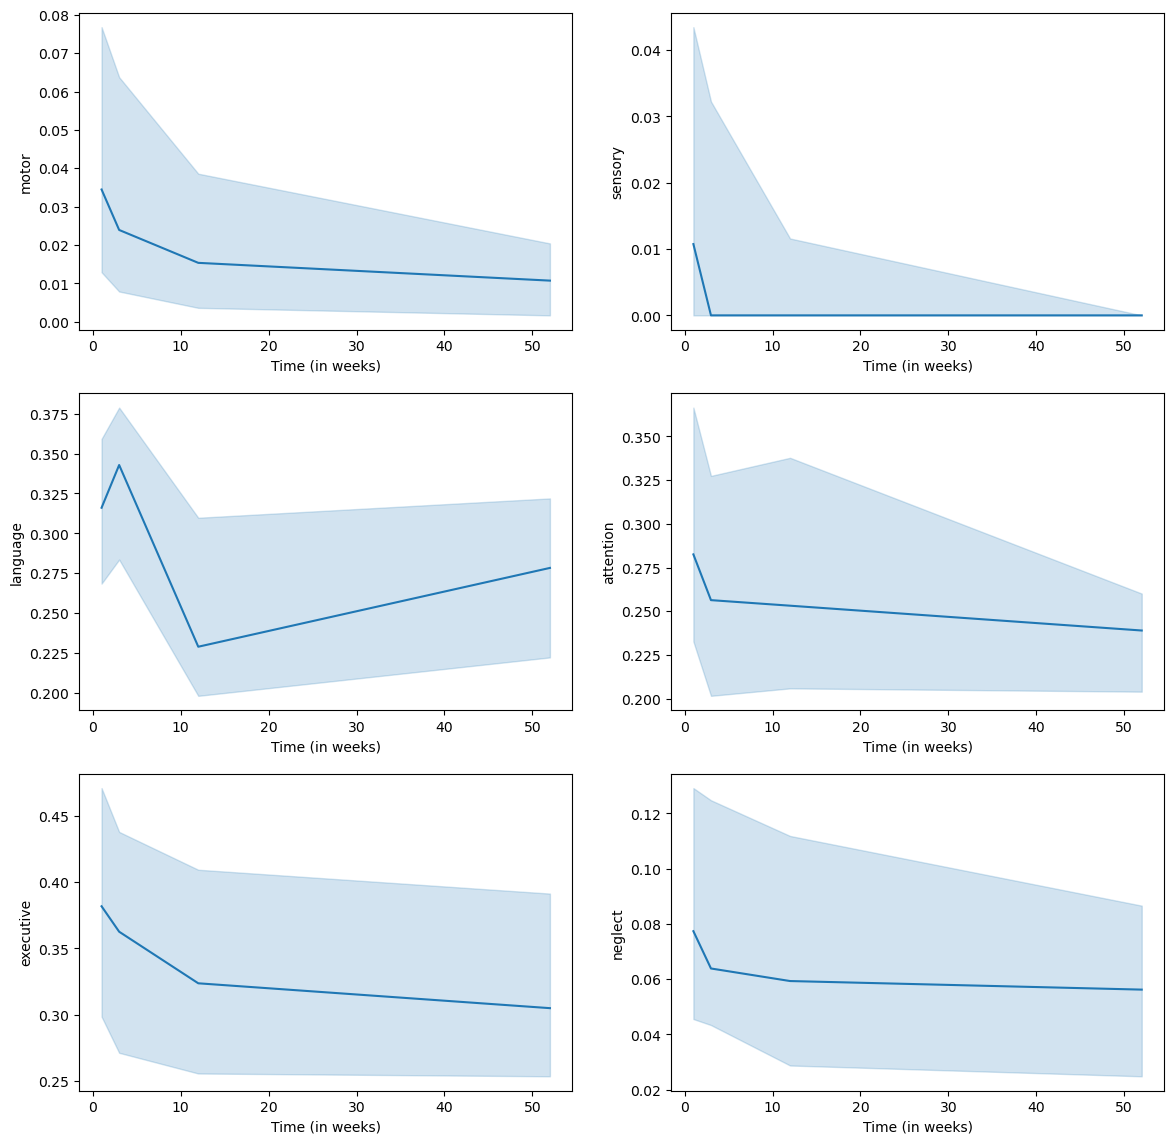

In [5]:
fig, ax = plt.subplots(n_domains//2, n_domains//3, figsize=(14,14))
for i in range(n_domains):
    sns.lineplot(data=NMF, x="time_in_weeks", y=domains[i], ax=ax[i%3, i%2], estimator = "median", errorbar=("pi", 50)) #hue="Labels", palette="tab10")
    ax[i%3, i%2].set_xlabel("Time (in weeks)")

### Performance for each domain over time for each patient

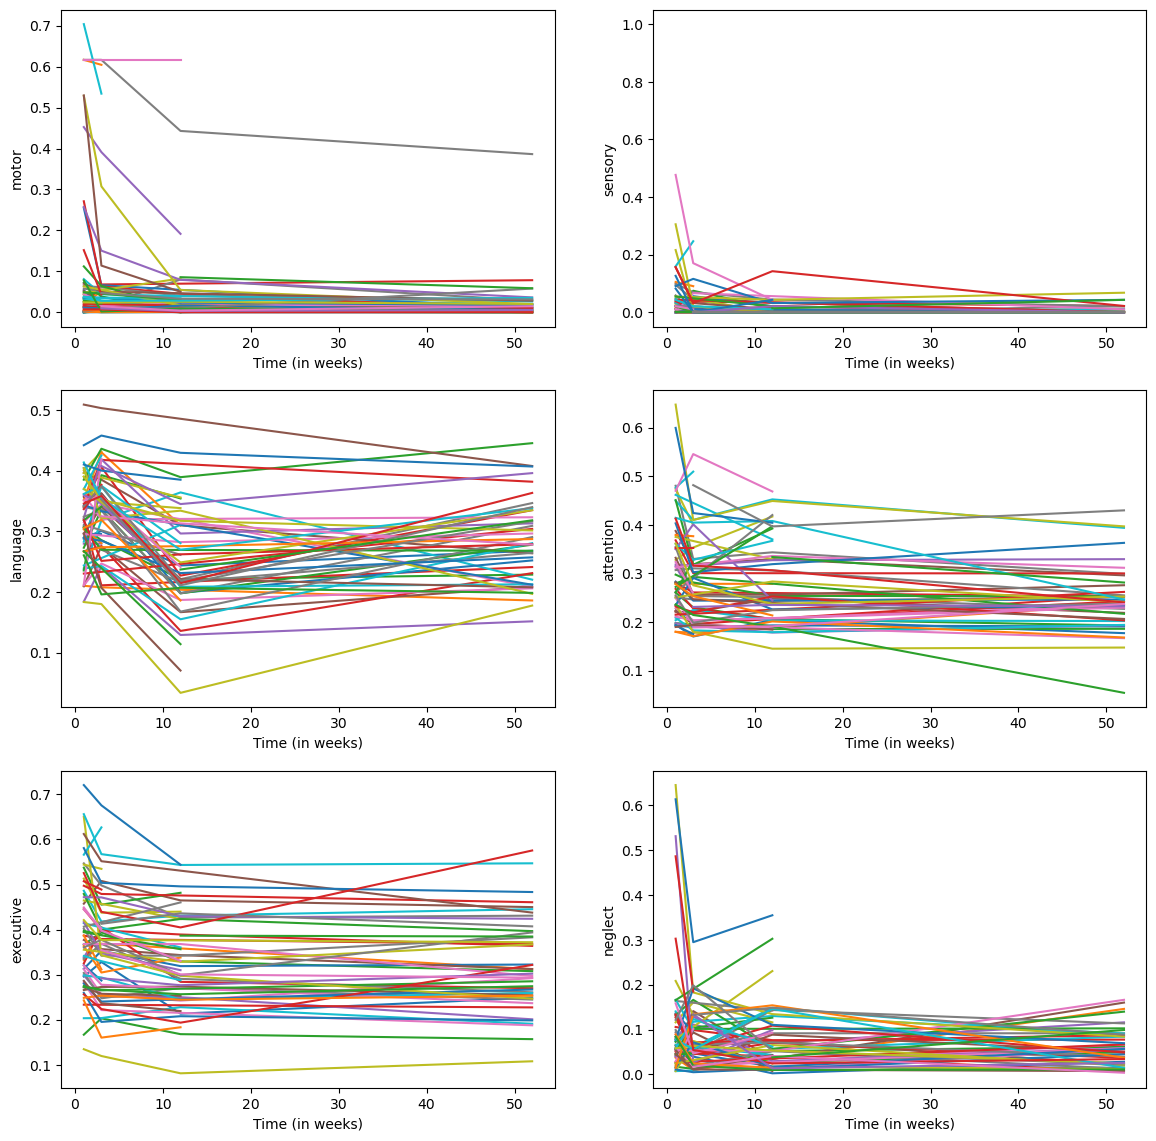

In [6]:
fig, ax = plt.subplots(n_domains//2, n_domains//3, figsize=(14,14))
for i in range(n_domains):
    sns.lineplot(data=NMF, x="time_in_weeks", y=domains[i], ax=ax[i%3, i%2], hue="Patient", palette="tab10", legend = False) 
    ax[i%3, i%2].set_xlabel("Time (in weeks)")

## Some observations about clusters in T1

In [7]:
# Add T0 label to each patient at the 3 other timepoints
NMF["Label_0"] = NMF.apply(lambda x: NMF_1[NMF_1["Patient"]==x["Patient"]]["Labels"].values[0].astype(str) if any(NMF_1["Patient"]==x["Patient"]) else np.nan, axis=1)
display(NMF)

,motor,attention,executive,sensory,language,neglect,Patient,Labels,time,time_in_weeks,Label_0
0,0.003716,0.194499,0.295743,0.000000,0.288797,0.056766,P001,0,1,1,0
1,0.036073,0.179785,0.332524,0.000000,0.210102,0.037255,P002,0,1,1,0
2,0.025385,0.260306,0.366695,0.000000,0.305543,0.017137,P003,0,1,1,0
3,0.011965,0.221951,0.386690,0.033708,0.319733,0.126463,P004,0,1,1,0
4,0.014486,0.314425,0.337978,0.000000,0.279560,0.078781,P005,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
41,0.020496,0.252341,0.371958,0.000000,0.301337,0.024519,P076,0,4,52,1
42,0.035450,0.246121,0.547071,0.000000,0.338208,0.014666,P077,1,4,52,1
43,0.031642,0.429661,0.407130,0.000000,0.339859,0.088666,P079,1,4,52,NaN
44,0.005167,0.054245,0.274303,0.000000,0.198389,0.011024,P081,0,4,52,0


In [8]:
def cluster_evolution(data,domains):
    n_domains = len(domains)
    fig, ax = plt.subplots(n_domains//2, n_domains//3, figsize=(14,14))
    for i in range(n_domains):
        sns.lineplot(data=data, x="time_in_weeks", y=domains[i], ax=ax[i%3, i%2], estimator = "median", errorbar=("pi", 50), hue="Label_0", palette=colormap_label_0)
        ax[i%3, i%2].set_xlabel("Time (in weeks)")

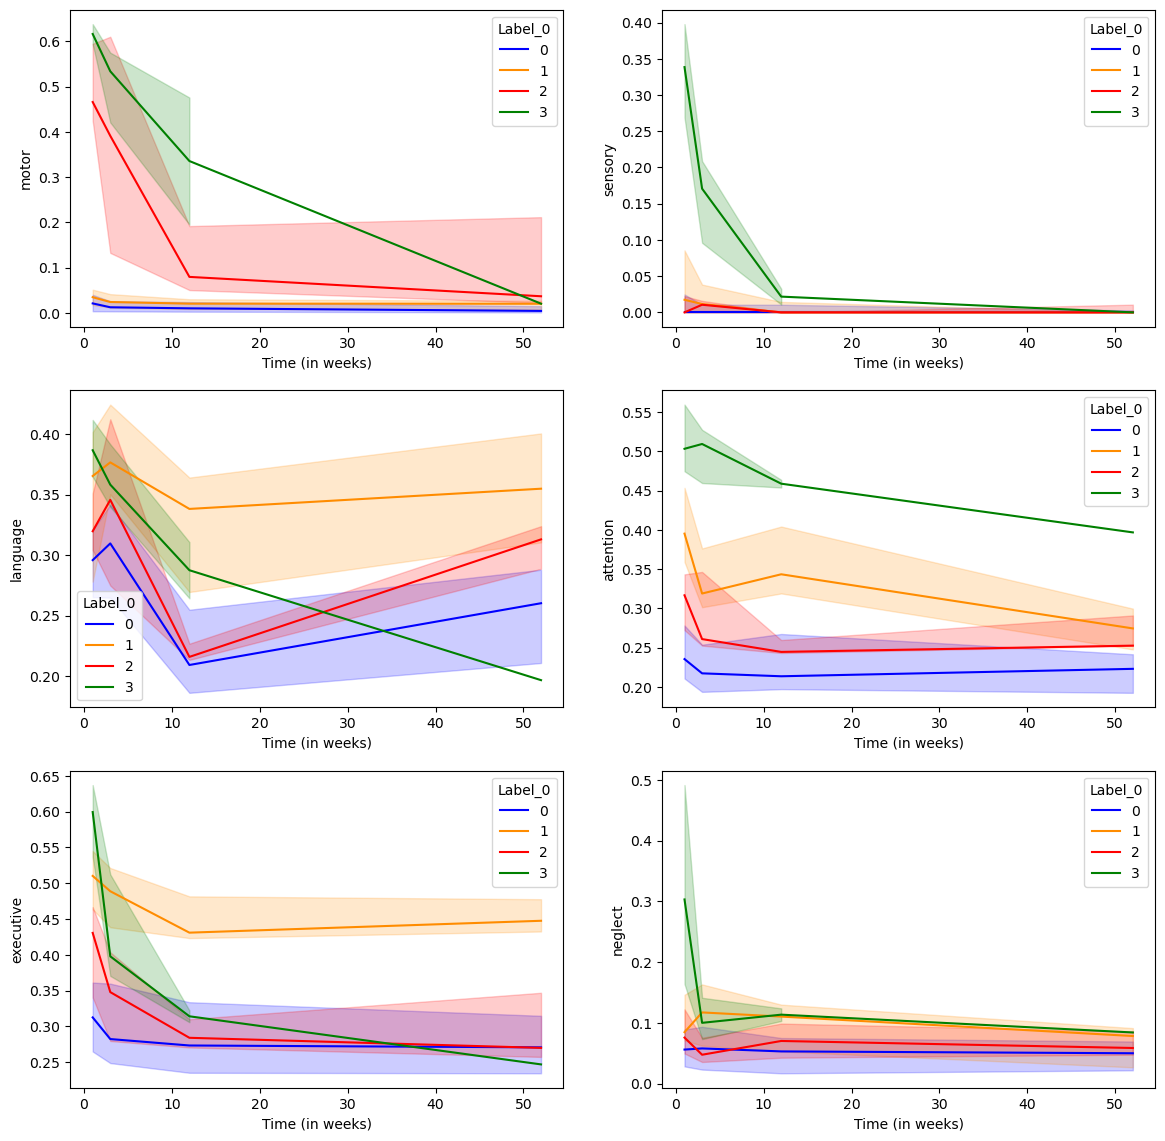

In [9]:
cluster_evolution(NMF,domains)

In [10]:
def radar_chart(data, nb_clusters=4):
    """ Compute radar chart for each timepoint, On each radar chart, each cluster median performance is represented by a line.
    Clusters can be found thanks to the column "Label_0" of the parameter data.
    """
    
    line_color = list(colormap_label_0.values())
    radial_axis_range = [0, 0.7]  

    for i in np.unique(data["time"]):
        data_time = data[data["time"] == i].drop(columns=['Patient', 'time', 'time_in_weeks', "Labels"])
        mean_performance = data_time.groupby("Label_0").median()
        
        fig = go.Figure()
        
        # For each cluster, add a trace 
        for j in range(nb_clusters):
            a = mean_performance.iloc[j].to_frame().reset_index().rename(columns={"index": "domain", str(j): "performance"})
            fig.add_trace(go.Scatterpolar(
                r=a['performance'],
                theta=a['domain'],
                mode='lines',
                name='Cluster ' + str(j),
                line_color=line_color[j]
            ))
        
        # Set a common radial axis range for consistency
        fig.update_layout(
            polar=dict(radialaxis=dict(range=radial_axis_range, visible=True)),
            showlegend=True,
            title=f'Radar Chart for Time: {i}'
        )

        # Display the radar chart
        fig.show()

In [11]:
radar_chart(NMF)

### Exploring patients who abandon or are added to the experiment

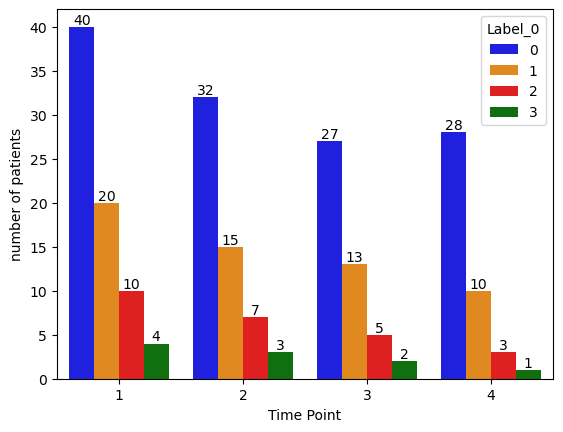

In [12]:
#Pour chaque cluster 0 at time 0, combien abandonne l'experience ?
df = (NMF.groupby(["time", "Label_0"])["Patient"].count().to_frame().reset_index())
ax = sns.barplot(data=df, x="time", y="Patient", hue="Label_0", palette=colormap_label_0)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)
ax.set(xlabel='Time Point', ylabel='number of patients')
plt.show()

In [13]:
patient_1 = NMF[NMF["time"] == "1"]["Patient"]
patient_2 = NMF[NMF["time"] == "2"]["Patient"]
patient_3 = NMF[NMF["time"] == "3"]["Patient"]
patient_4 = NMF[NMF["time"] == "4"]["Patient"]

drop_out_1_2 = patient_1[~patient_1.isin(patient_2)]
drop_out_2_3 = patient_2[~patient_2.isin(patient_3)]
drop_out_3_4 = patient_3[~patient_3.isin(patient_4)]

add_1_2 = patient_2[~patient_2.isin(patient_1)]
add_2_3 = patient_3[~patient_3.isin(patient_2)]
add_3_4 = patient_4[~patient_4.isin(patient_3)]

print("Drop out from time 1 to time 2: ", drop_out_1_2.to_list())
print("Drop out from time 2 to time 3: ", drop_out_2_3.to_list())
print("Drop out from time 3 to time 4: ", drop_out_3_4.to_list())
print("Add from time 1 to time 2: ", add_1_2.to_list())
print("Add from time 2 to time 3: ", add_2_3.to_list())
print("Add from time 3 to time 4: ", add_3_4.to_list())

Drop out from time 1 to time 2:  ['P007', 'P023', 'P028', 'P032', 'P034', 'P043', 'P045', 'P047', 'P049', 'P050', 'P053', 'P058', 'P061', 'P064', 'P065', 'P070', 'P072']
Drop out from time 2 to time 3:  ['P002', 'P004', 'P005', 'P009', 'P022', 'P026', 'P030', 'P035', 'P037', 'P040', 'P044', 'P046', 'P056', 'P059', 'P062', 'P063', 'P071', 'P083', 'P085', 'P086']
Drop out from time 3 to time 4:  ['P012', 'P020', 'P025', 'P029', 'P032', 'P043', 'P048', 'P051', 'P053', 'P066', 'P070', 'P073', 'P074', 'P078', 'P080']
Add from time 1 to time 2:  ['P024', 'P026', 'P069', 'P079', 'P083', 'P085', 'P086']
Add from time 2 to time 3:  ['P032', 'P043', 'P050', 'P051', 'P052', 'P053', 'P065', 'P070']
Add from time 3 to time 4:  ['P002', 'P004', 'P030', 'P037', 'P040', 'P044', 'P046', 'P047', 'P062']
